# Key Question

Why are there bad comments?  
Is it due to late deliveries? Defective products?

If it is due to bad delivery, why?

Sélectionner un produit et ressortie les mots la ou les raisons des notes négatives

# Preprocessing

### Import and files

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from tqdm import tqdm

from PIL import Image
import random
import unicodedata
import re

nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

: 

In [ ]:
import os
import warnings

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')


: 

### Open Files

In [ ]:
order_s = pd.read_csv('./data/olist_orders_dataset.csv')
# customer_s = pd.read_csv('./data/olist_customers_dataset.csv')
# payment = pd.read_csv('./data/olist_order_payments_dataset.csv')
order_item = pd.read_csv('./data/olist_order_items_dataset.csv')
# product = pd.read_csv('./data/olist_products_dataset.csv')
reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
# category = pd.read_csv('./data/product_category_name_translation.csv')
# cat_name_translation = pd.read_csv(
#     './data/product_category_name_translation.csv')


: 

In [ ]:
print(
    'orders data shape:',
    order_s.shape,
    # '\ncustomer data shape:',
    # customer_s.shape,
    # '\npayment data shape:',
    # payment.shape,
    '\norder_item data shape:',
    order_item.shape,
    # '\nproduct data shape:',
    # product.shape,
    '\nreview data shape:',
    reviews.shape,
    # '\nlanguage data shape:',
    # cat_name_translation.shape,
)


: 

In [ ]:
order_s.head(15)


: 

In [ ]:
order_item.head(15)


: 

In [ ]:
reviews.head(15)


: 

### Convert DateTime & Merge Table

In [ ]:
reviews['review_creation_date'] = pd.to_datetime(
    reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
reviews['review_answer_timestamp'] = pd.to_datetime(
    reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
order_s['order_purchase_timestamp'] = pd.to_datetime(
    order_s['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
order_s['order_delivered_customer_date'] = pd.to_datetime(
    order_s['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')


: 

In [ ]:
reviews = pd.merge(reviews, order_s, on='order_id')


: 

In [ ]:
to_drop = [
    'review_id', 'customer_id', 'review_comment_title',
    'order_approved_at', 'order_delivered_carrier_date',
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)
reviews


: 

In [ ]:
reviews_na = reviews.where(reviews.isna() == False).dropna()
reviews_na.head(15)


: 

### Average & Percentage

In [ ]:
ps_5 = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
ps_1 = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
avg_s = reviews['review_score'].mean()

print(
    f'Total number of reviews: {len(reviews)}',
    '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
    '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
    '\nAverage review score: {:.2f}'.format(avg_s),
)


: 

In [ ]:
ps_5 = len(reviews_na[reviews_na['review_score'] == 5]) * 100 / len(reviews_na)
ps_1 = len(reviews_na[reviews_na['review_score'] == 1]) * 100 / len(reviews_na)
avg_s = reviews_na['review_score'].mean()

print(
    f'Total number of reviews: {len(reviews_na)}',
    '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
    '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
    '\nAverage review score: {:.2f}'.format(avg_s),
)


: 

### Play with Seaborn

In [ ]:
sns.set()

COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette(
    (COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

resize_plot = lambda: plt.gcf().set_size_inches(20, 5)


: 

In [ ]:
sns.catplot(x='review_score',
            kind='count',
            data=reviews,
            palette=REVIEWS_PALETTE).set(
                xlabel='Review Score',
                ylabel='Number of Reviews',
            )


: 

In [ ]:
sns.catplot(x='review_score',
            kind='count',
            data=reviews_na,
            palette=REVIEWS_PALETTE).set(
                xlabel='Review Score',
                ylabel='Number of Reviews',
            )


: 

In [ ]:
reviews_na['review_creation_delay'] = (
    reviews_na['review_creation_date'] -
    reviews_na['order_purchase_timestamp']).dt.days

sns.scatterplot(x='order_purchase_timestamp',
                y=reviews_na['review_creation_delay'],
                hue='review_score',
                data=reviews,
                palette=REVIEWS_PALETTE).set(
                    xlabel='Order Purchase Timestamp',
                    ylabel='Review Creation Delay',
                    xlim=(reviews_na['order_purchase_timestamp'].min()))


: 

In [ ]:
reviews_na['review_length'] = reviews_na['review_comment_message'].str.len()

g = sns.FacetGrid(data=reviews_na,
                  col='review_score',
                  hue='review_score',
                  palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(15, 7)


: 

### Tokenization

In [ ]:
avg = sum([len(rv.split()) for rv in reviews_na['review_comment_message']
           ]) / len(reviews_na['review_comment_message'])
avg


: 

In [ ]:
reviews_na['review_comment_message'] = reviews_na[
    'review_comment_message'].str.lower()
reviews_na['review_comment_message'][3:4]


: 

With Python's librairies

In [ ]:
tk_py = list()
for rv in tqdm(reviews_na['review_comment_message']):
    tk_py.append(rv.split())

print(tk_py[:20])


: 

With REGEX

In [ ]:
tk_rgx = list()
for rv in tqdm(reviews_na['review_comment_message']):
    tk_rgx.append(re.findall('[\w]+', rv))

print(tk_rgx[:20])


: 

With NLTK

In [ ]:
tk_nltk = list()
for rv in tqdm(reviews_na['review_comment_message']):
    tk_nltk.append(nltk.tokenize.word_tokenize(rv))

print(tk_nltk[:20])


: 

### Basic NLP

In [204]:
def remove_accents(ptg: float) -> str:
    return unicodedata.normalize('NFKD',
                                 ptg).encode('ascii',
                                             errors='ignore').decode('utf-8')


STOP_WORDS = set(
    remove_accents(w) for w in tqdm(nltk.corpus.stopwords.words('portuguese')))
STOP_WORDS.remove('nao')

100%|██████████| 207/207 [00:00<00:00, 414030.01it/s]


In [205]:
def tokenize(data: str) -> tuple:
    normalized = remove_accents(data)
    tokens = nltk.tokenize.word_tokenize(normalized)
    # tokens = re.findall('[\w]+', normalized)
    return tuple(
        [tk for tk in tokens if tk not in STOP_WORDS and tk.isalpha()])


def ngrams(tokens: tuple) -> list:
    unigrams, bigrams, trigrams = [], [], []
    for tk in tokens:
        unigrams.extend(tk)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(tk))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(tk))

    return unigrams, bigrams, trigrams


In [206]:
reviews_na['review_comment_words'] = reviews_na[
    'review_comment_message'].apply(tokenize)

reviews_5s = reviews_na[reviews_na['review_score'] == 5]
reviews_1s = reviews_na[reviews_na['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = ngrams(
    reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = ngrams(
    reviews_1s['review_comment_words'])


In [207]:
def plot_freq(tokens: tuple, color: str) -> None:
    resize_plot()
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)


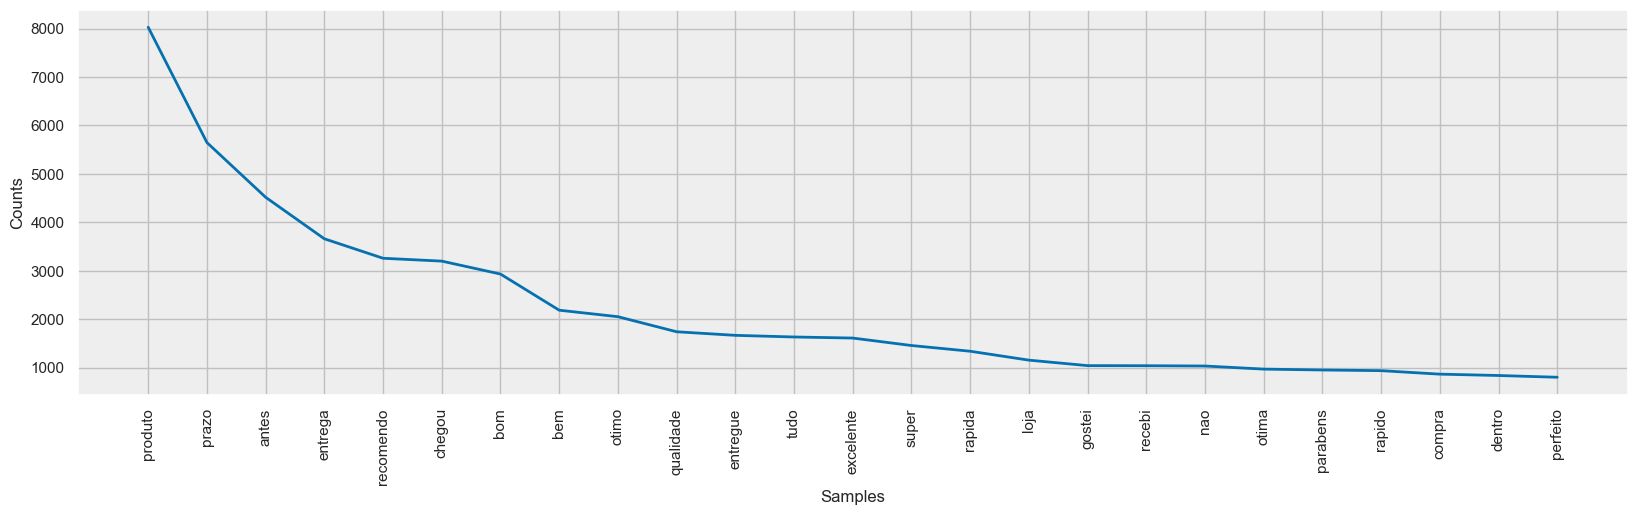

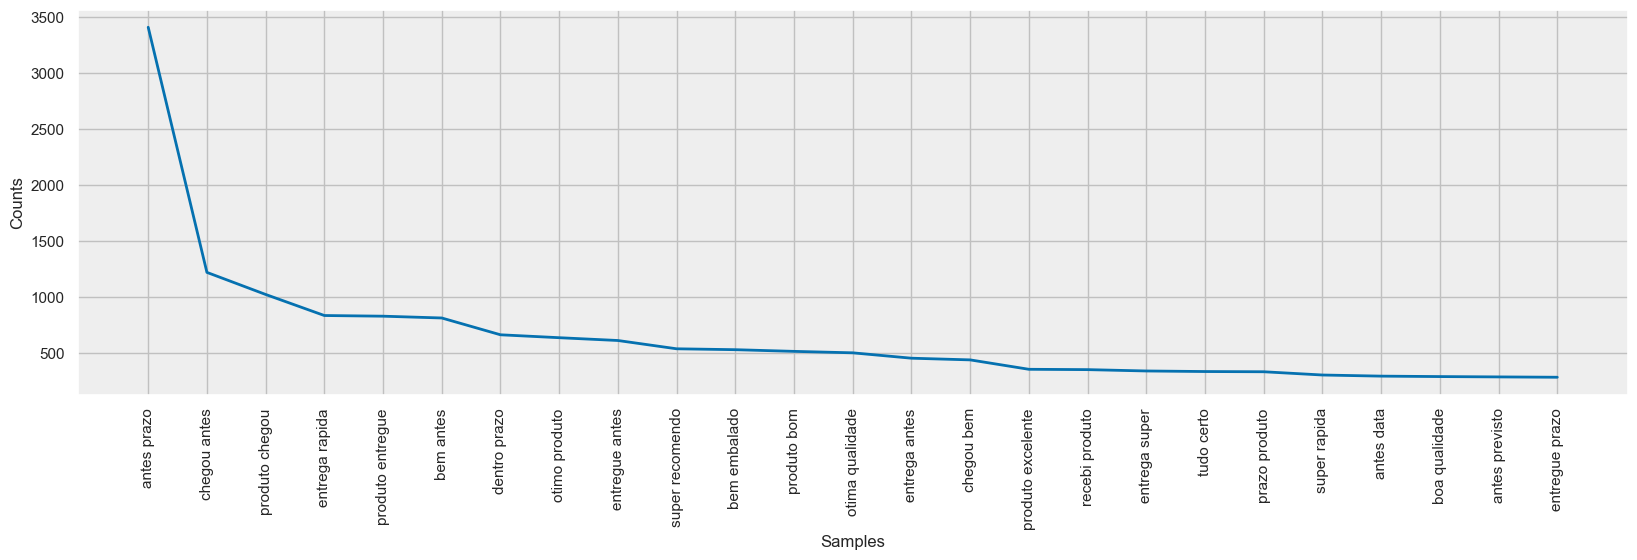

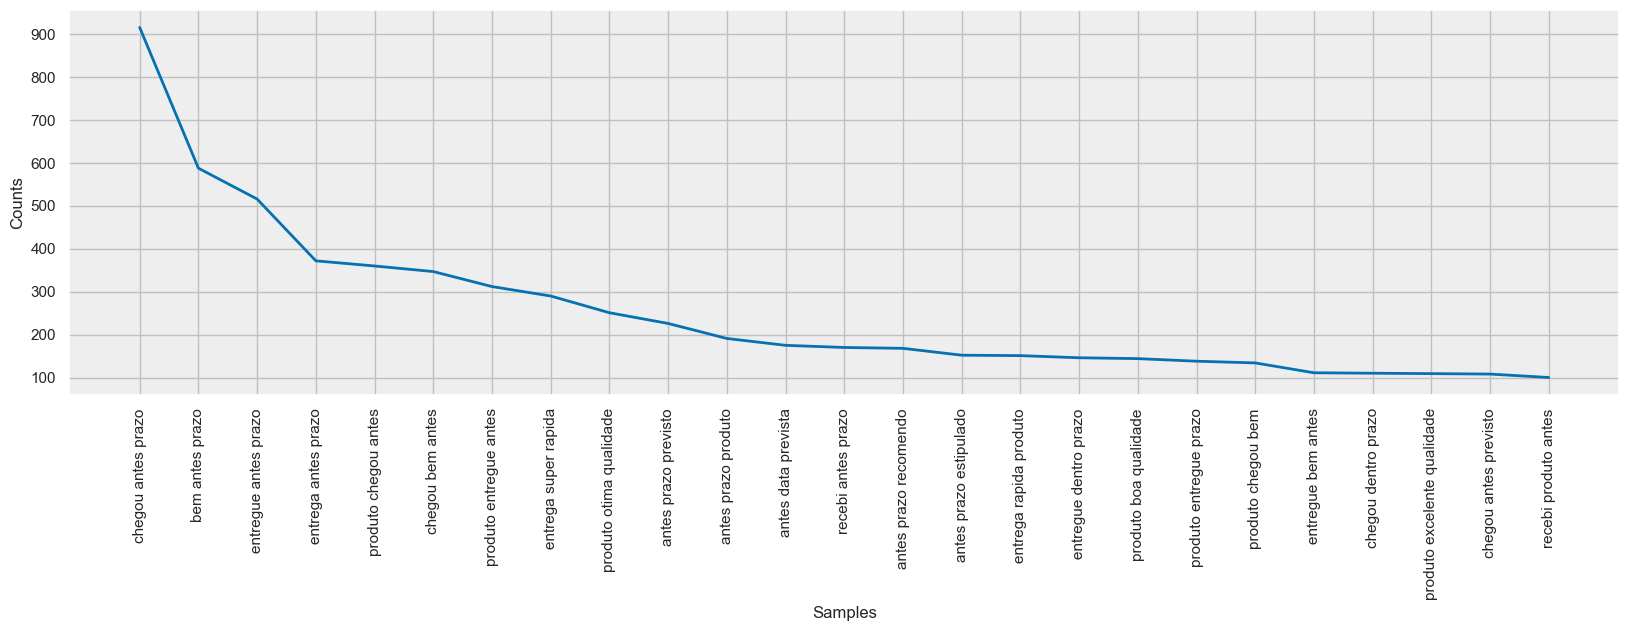

In [208]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)


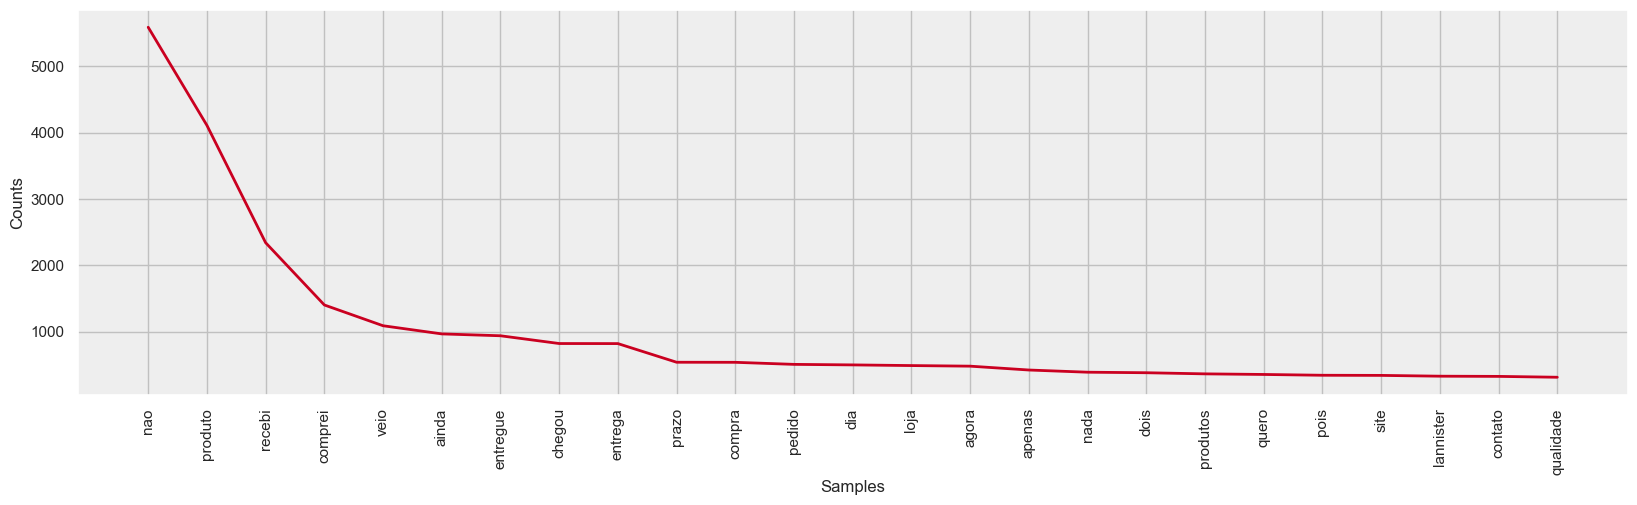

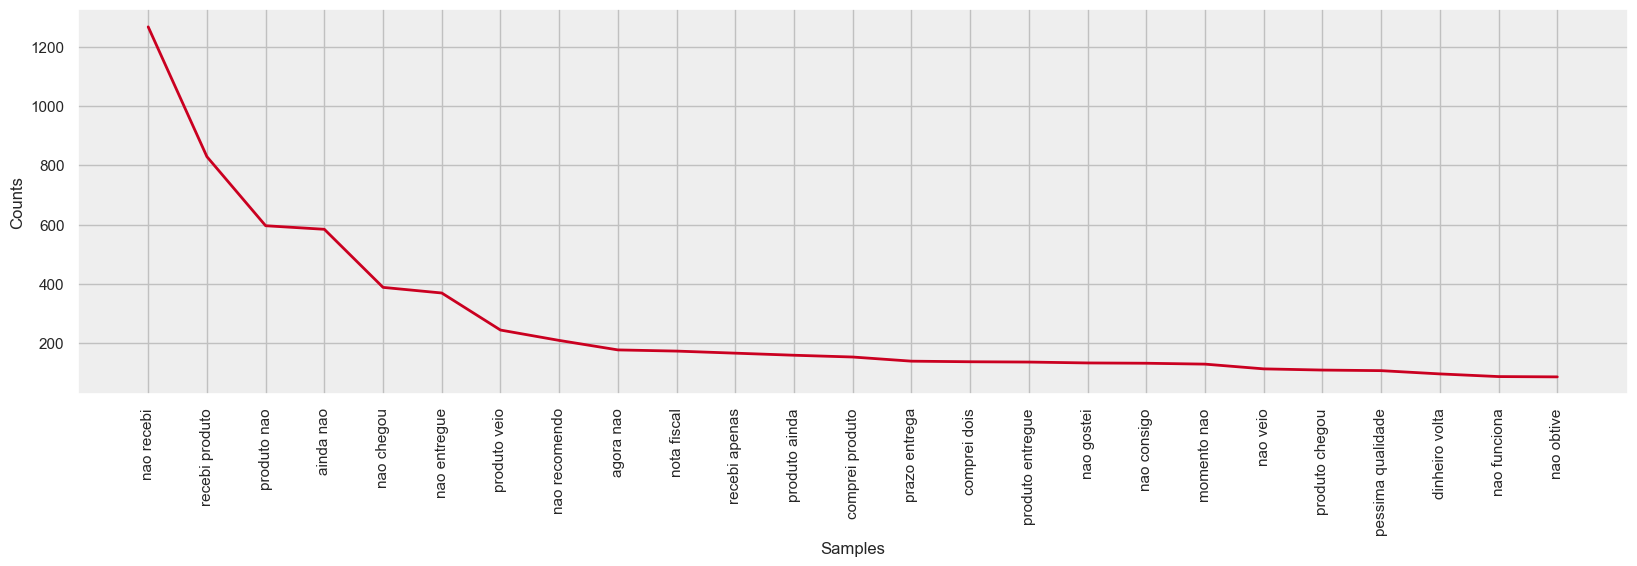

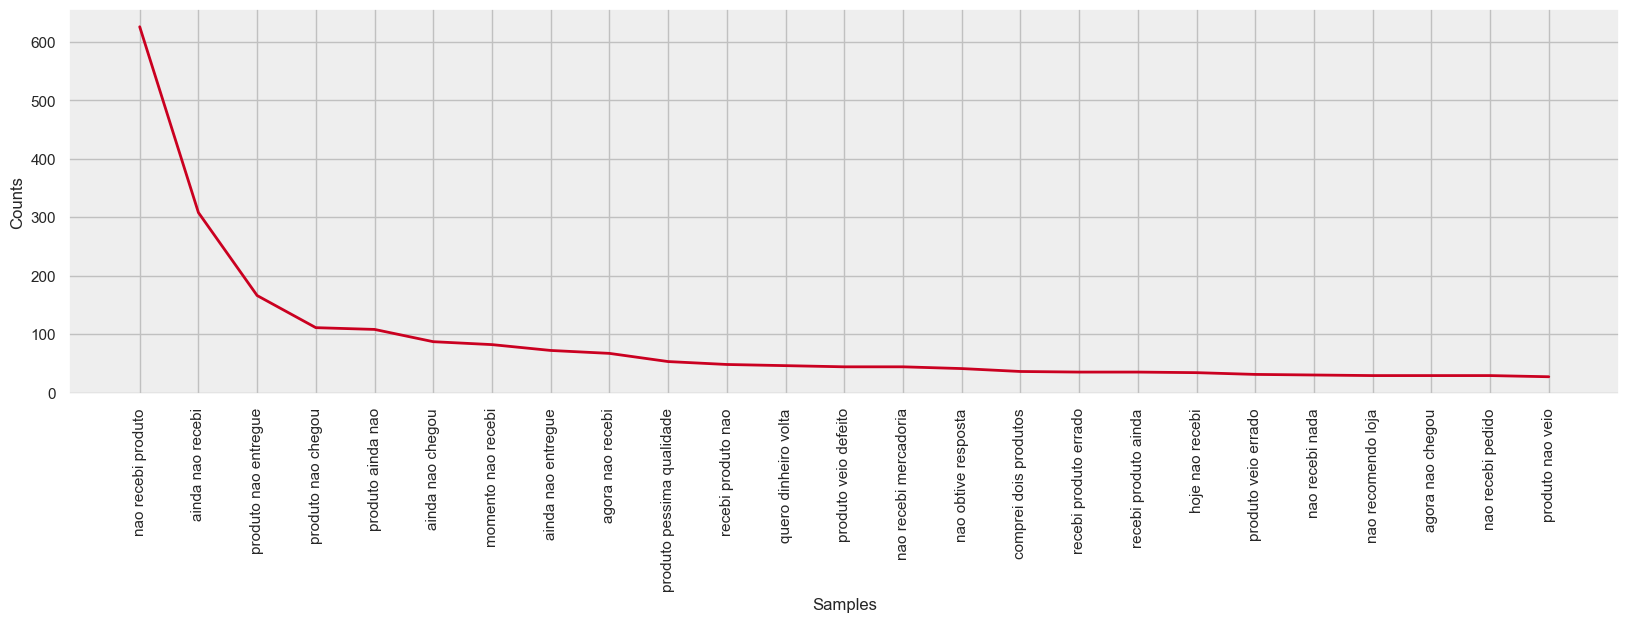

In [209]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)


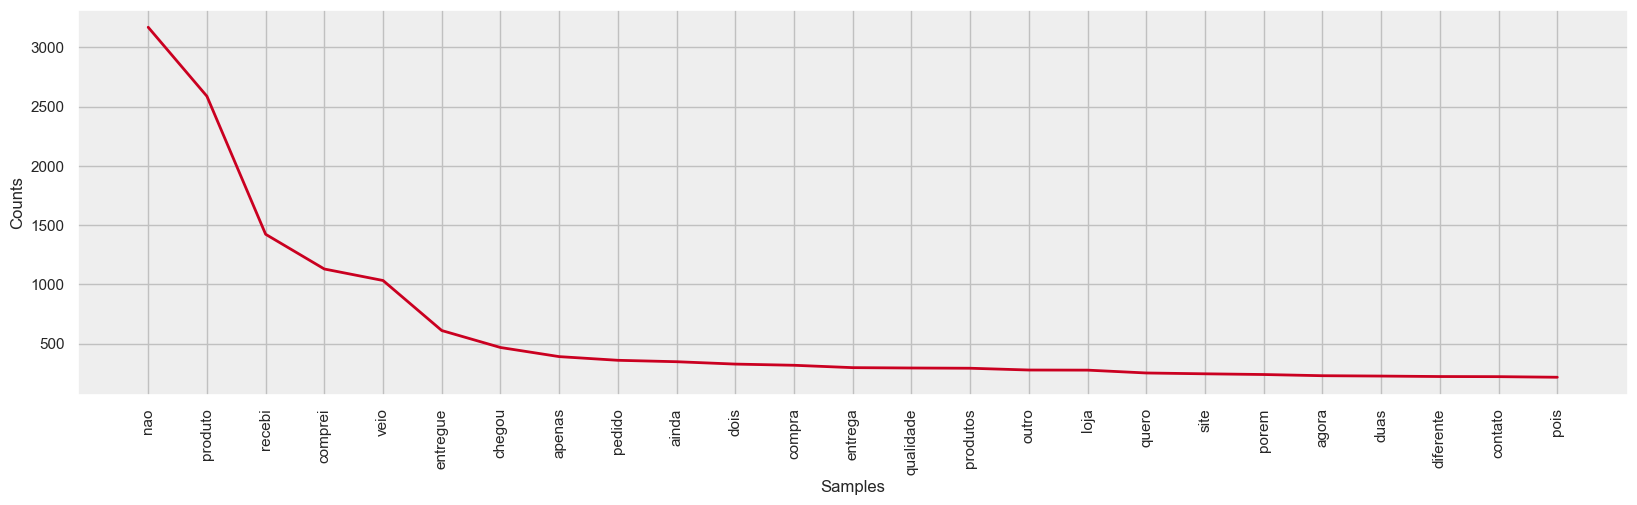

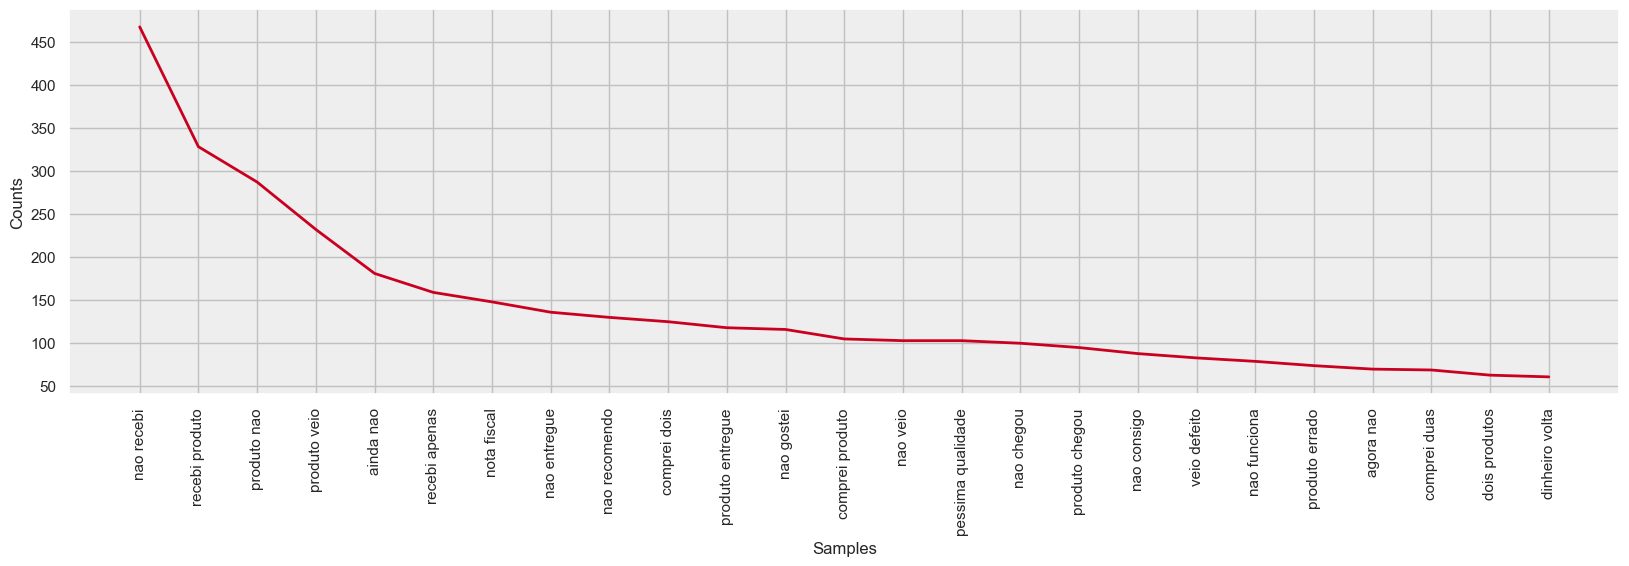

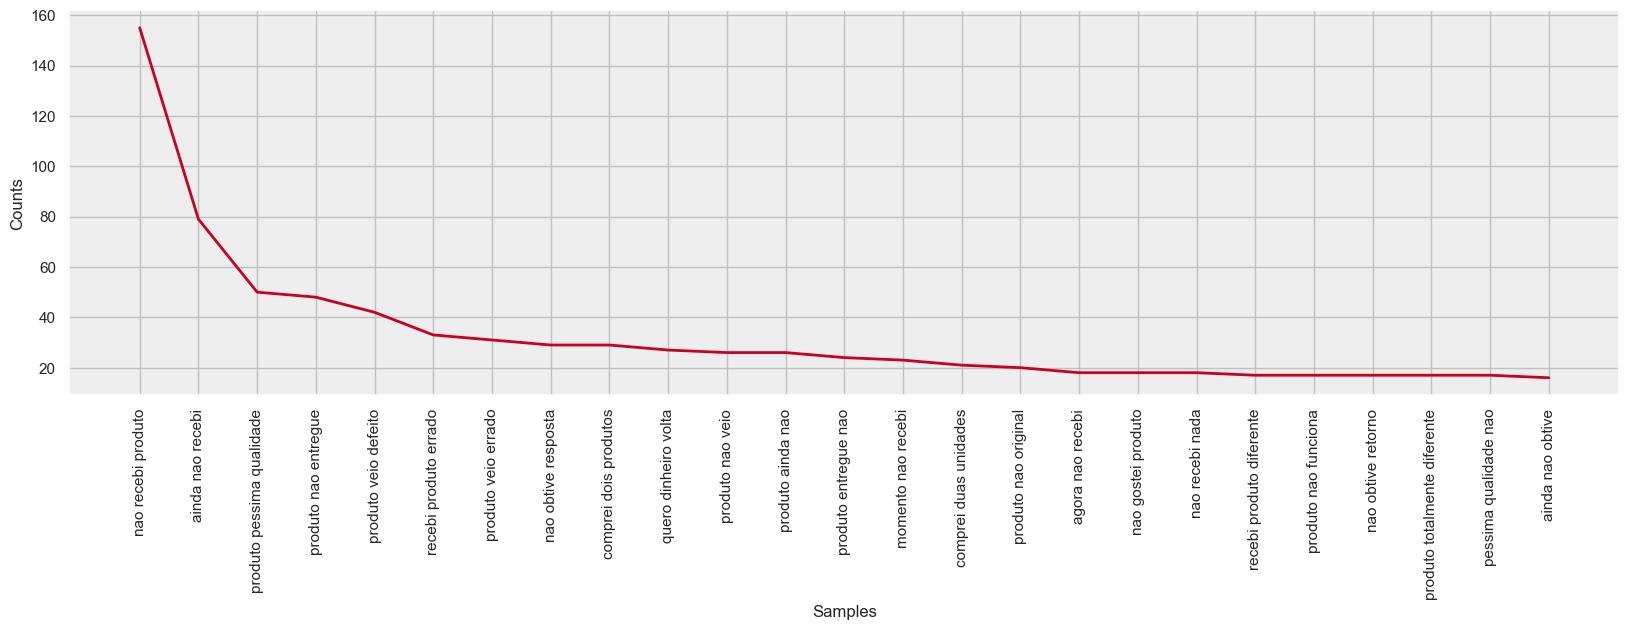

In [210]:
reviews_delivered_1s = reviews_na[(reviews_na['review_score'] == 1) &
                                  (reviews_na['order_delivered_customer_date']
                                   < reviews_na['review_creation_date'])]
unigrams_d1s, bigrams_d1s, trigrams_d1s = ngrams(
    reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
plot_freq(bigrams_d1s, COLOR_1S)
plot_freq(trigrams_d1s, COLOR_1S)


OLIST_ORDER_ITEMS_DATASET -> OLIST_ORDER_REVIEWS_DATASET

In [211]:
reviews_na


,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date,review_creation_delay,review_length,review_comment_words
3,658677c97b385a9be170737859d3511b,5,recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35,11,37,"(recebi, bem, antes, prazo, estipulado)"
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,parabéns lojas lannister adorei comprar pela i...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35,18,100,"(parabens, lojas, lannister, adorei, comprar, ..."
9,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,delivered,2018-05-14 10:29:02,2018-05-21 17:52:12,7,174,"(aparelho, eficiente, site, marca, aparelho, i..."
12,9d6f15f95d01e79bd1349cc208361f09,4,"mas um pouco ,travando...pelo valor ta boa.\r\n",2018-02-16,2018-02-20 10:52:22,delivered,2018-02-12 16:07:34,2018-02-15 19:16:54,3,45,"(pouco, travando, valor, ta, boa)"
15,e51478e7e277a83743b6f9991dbfa3fb,5,"vendedor confiável, produto ok e entrega antes...",2018-05-23,2018-05-24 03:00:01,delivered,2018-05-18 18:20:45,2018-05-22 14:58:47,4,56,"(vendedor, confiavel, produto, ok, entrega, an..."
...,...,...,...,...,...,...,...,...,...,...,...
99205,d398e9c82363c12527f71801bf0e6100,4,para este produto recebi de acordo com a compr...,2017-11-29,2017-11-30 15:52:51,delivered,2017-11-19 11:56:42,2017-11-28 01:33:13,9,58,"(produto, recebi, acordo, compra, realizada)"
99208,509b86c65fe4e2ad5b96408cfef9755e,5,entregou dentro do prazo. o produto chegou em ...,2018-02-07,2018-02-19 19:47:23,delivered,2018-01-31 23:37:38,2018-02-06 18:12:22,6,91,"(entregou, dentro, prazo, produto, chegou, con..."
99215,d5cb12269711bd1eaf7eed8fd32a7c95,3,"o produto não foi enviado com nf, não existe v...",2018-05-19,2018-05-20 21:51:06,delivered,2018-05-14 17:00:31,2018-05-18 17:12:51,4,125,"(produto, nao, enviado, nf, nao, existe, venda..."
99221,55d4004744368f5571d1f590031933e4,5,"excelente mochila, entrega super rápida. super...",2018-03-22,2018-03-23 09:10:43,delivered,2018-03-18 09:52:19,2018-03-21 17:44:08,3,67,"(excelente, mochila, entrega, super, rapida, s..."


In [212]:
str(reviews_na['order_id'][0:1].values[0])


'658677c97b385a9be170737859d3511b'

In [213]:
# order_item[order_item['order_id'] == str(reviews_na['order_id'][0:1].values[0])]
order_item[order_item['order_id'] == '658677c97b385a9be170737859d3511b']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
44664,658677c97b385a9be170737859d3511b,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85


In [214]:
def search_product(product_id: str, dataframe: bool, stats: bool):
    product_link = order_item[order_item['product_id'] == product_id]

    if len(product_link) == 0:
        print(f'This product\'s id {product_id} was not found')
        return pd.DataFrame(data=product_link)

    reviews_order = reviews_na[reviews_na['order_id'].isin(
        product_link['order_id'])]

    if len(reviews_order) == 0:
        print(f'There no reviews founded for {product_id}')
        return pd.DataFrame(data=reviews_order)

    if stats:
        ps_5 = len(reviews_order[reviews_order['review_score'] ==
                                 5]) * 100 / len(reviews_order)
        ps_1 = len(reviews_order[reviews_order['review_score'] ==
                                 1]) * 100 / len(reviews_order)
        avg_s = reviews_order['review_score'].mean()

        print(
            f'Total number of reviews: {len(reviews_order)}',
            '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
            '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
            '\nAverage review score: {:.2f}'.format(avg_s),
        )

    if dataframe: return reviews_order


In [215]:
reviews_prod = search_product(product_id='52c80cedd4e90108bf4fa6a206ef6b03',
                              dataframe=True,
                              stats=True)

print('Dataframe vide ?!'
      ) if reviews_prod.empty is True else reviews_prod.head()


Total number of reviews: 41 
Percentage of 5 star reviews: 58.54% 
Percentage of 1 star reviews: 17.07% 
Average review score: 3.98


,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date,review_creation_delay,review_length,review_comment_words
3,658677c97b385a9be170737859d3511b,5,recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35,11,37,"(recebi, bem, antes, prazo, estipulado)"
351,7368e14d8b9e7b886e433697b89e937c,3,faltaram os cabos e o manual,2018-02-27,2018-03-02 00:24:24,delivered,2018-02-15 11:26:55,2018-02-26 21:10:23,11,28,"(faltaram, cabos, manual)"
9229,cad39f1647e3828163e49718ea495994,5,100% eficiente,2017-11-11,2017-11-12 11:09:30,delivered,2017-10-29 16:24:24,2017-11-10 22:31:45,12,15,"(eficiente,)"
11667,9065442ba82e20a8ec900872056f9b35,5,muito satisfeito,2018-05-10,2018-05-11 02:26:43,delivered,2018-04-23 16:45:47,2018-05-09 21:41:42,16,16,"(satisfeito,)"
11908,e35bd284b205ea082108ae3703c84428,4,"tudo em ordem , posso confiar.",2017-11-23,2017-11-25 19:29:11,delivered,2017-11-10 13:42:22,2017-11-22 14:12:32,12,30,"(tudo, ordem, posso, confiar)"


chauqe cause : mot répérer 

tfidf sur les chaines de commentaires
représentations tfidf
regarder 

avoir des commentaires exemples

In [216]:
reviews_prod['review_comment_words'] = reviews_prod[
    'review_comment_message'].apply(tokenize)

reviews_5s = reviews_prod[reviews_prod['review_score'] == 5]
reviews_1s = reviews_prod[reviews_prod['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = ngrams(
    reviews_5s['review_comment_words'])

unigrams_1s, bigrams_1s, trigrams_1s = ngrams(
    reviews_1s['review_comment_words'])


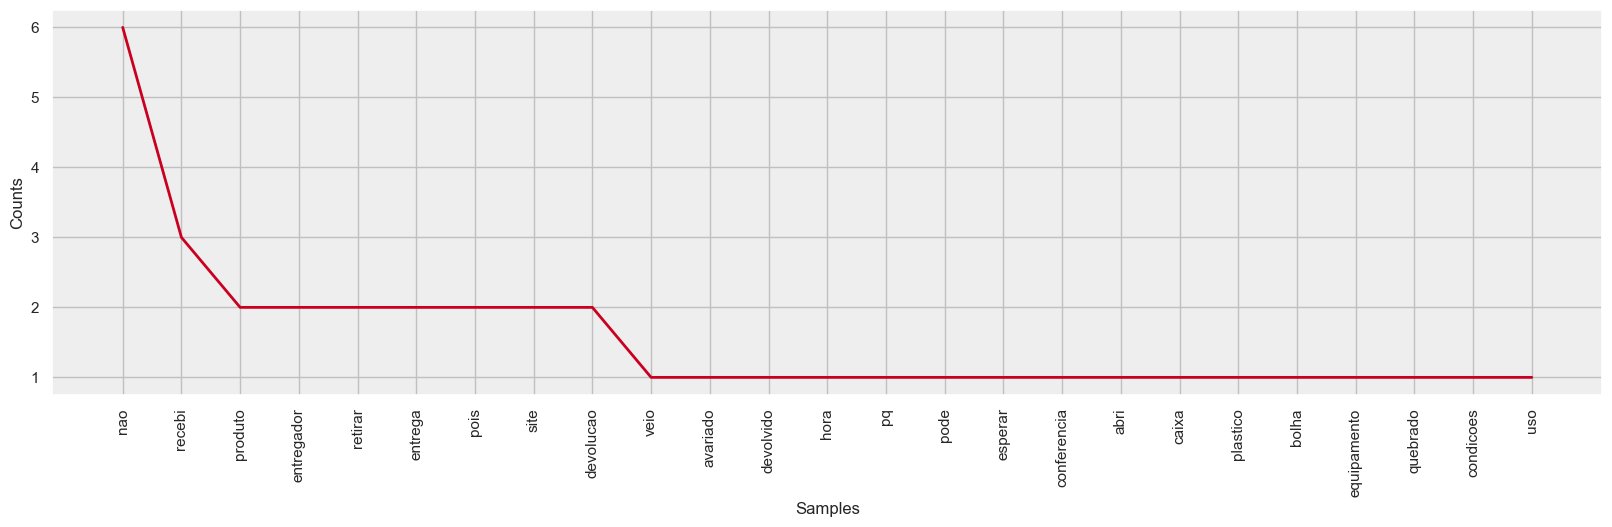

In [217]:
reviews_delivered_1s = reviews_prod[(reviews_prod['review_score'] == 1) & (reviews_prod['order_delivered_customer_date'] < reviews_prod['review_creation_date'])]
unigrams_d1s, bigrams_d1s, trigrams_d1s = ngrams(reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
# plot_freq(bigrams_d1s, COLOR_1S)
# plot_freq(trigrams_d1s, COLOR_1S)


In [218]:
def rgb_float_to_int(rgb):
    return tuple(int(255 * c) for c in rgb)


WORDCLOUD_1S_PALETTE = [
    rgb_float_to_int(rgb) for rgb in sns.color_palette('Reds', n_colors=9)[2:]
]
WORDCLOUD_5S_PALETTE = [
    rgb_float_to_int(rgb) for rgb in sns.color_palette('Blues', n_colors=9)[2:]
]


def get_1s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_1S_PALETTE)


def get_5s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_5S_PALETTE)


In [229]:
def plot_wordcloud(words, style):
    if style == '1s':
        color_function = get_1s_color
        mask_fn = 'thumbs_down.png'
    elif style == '5s':
        color_function = get_5s_color
        mask_fn = 'thumbs_up.png'

    mask = np.array(Image.open(f'./input/{mask_fn}'))

    wordcloud = WordCloud(background_color='white', mask=mask, random_state=42, stopwords=STOP_WORDS)
    wordcloud.generate(' '.join(words))
    wordcloud.recolor(color_func=color_function)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.gcf().set_size_inches(16, 10)


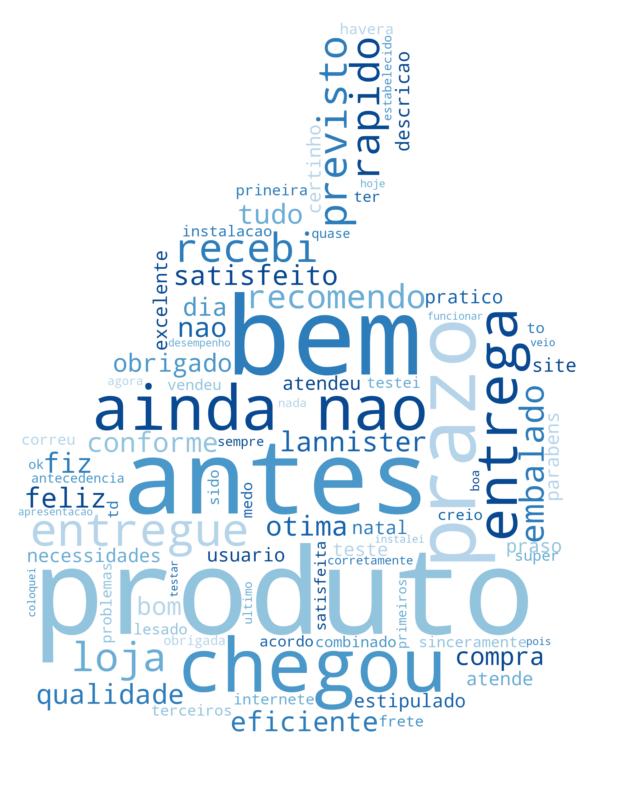

In [232]:
plot_wordcloud(unigrams_5s, '5s')


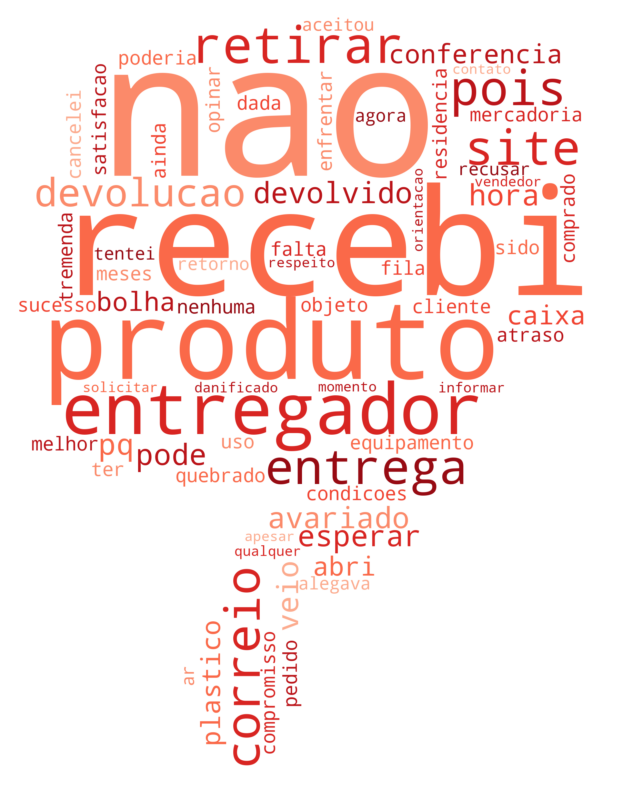

In [233]:
plot_wordcloud(unigrams_1s, '1s')
